$$\huge \text {Computer Assignment 4 - Neural Networks}$$

$$\large \text {In this project, we want to build an image classification model using a Neural Network.}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import copy
import os
from sklearn.model_selection import train_test_split
import pickle

***
# Building the dataframe

In [2]:
df = pd.read_csv("cifar_dataset/labels.csv", index_col='id')
df['img'] = None
df.head()

,label,img
id,,
8,horse,None
10,cat,None
12,horse,None
13,horse,None
18,cat,None


In [3]:
path = "cifar_dataset/data/"
img_ids = os.listdir(path)
for i in range(len(img_ids)):
    img_ids[i] = img_ids[i].removesuffix('.png')
for img_id in img_ids:
    img = Image.open(f'{path}/{img_id}.png')
    imgGray = img.convert('L')
    numpydata = np.asarray(imgGray)
    df.loc[int(img_id)].img = numpydata
    
df.head()

,label,img
id,,
8,horse,"[[33, 34, 41, 75, 76, 43, 42, 56, 70, 77, 102,..."
10,cat,"[[124, 103, 93, 99, 101, 136, 171, 170, 143, 9..."
12,horse,"[[147, 171, 169, 173, 201, 212, 196, 135, 119,..."
13,horse,"[[203, 200, 200, 201, 201, 201, 202, 202, 202,..."
18,cat,"[[105, 135, 145, 130, 82, 55, 48, 52, 52, 53, ..."


***
# Part One: Pre-processing

## test-train split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2)

## Random image from the training data

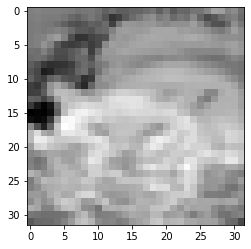

In [5]:
sample = copy.deepcopy(X_train.sample().img)
sample = sample.values.item()
imgplot = plt.imshow(sample, cmap=plt.get_cmap('gray'))

### The values of each pixel is between 0 and 255

## Random image from each class of the training data

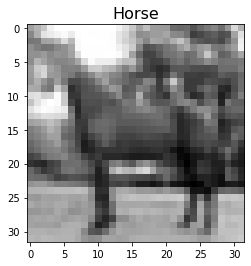

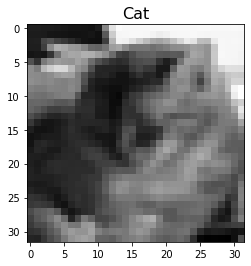

In [6]:
horse_sample_id = y_train[y_train == 'horse'].sample().index
cat_sample_id = y_train[y_train == 'cat'].sample().index
horse_sample = copy.deepcopy(X_train.loc[horse_sample_id].img)
cat_sample = copy.deepcopy(X_train.loc[cat_sample_id].img)
horse_sample = horse_sample.values.item()
cat_sample = cat_sample.values.item()
plt.imshow(horse_sample, cmap=plt.get_cmap('gray'))
plt.title("Horse", fontsize=16)
plt.show()
plt.imshow(cat_sample, cmap=plt.get_cmap('gray'))
plt.title("Cat", fontsize=16)
plt.show()

## The number of images in each class

In [7]:
train_horse_no = y_train[y_train == 'horse'].shape[0]
train_cat_no = y_train[y_train == 'cat'].shape[0]

test_horse_no = y_test[y_test == 'horse'].shape[0]
test_cat_no = y_test[y_test == 'cat'].shape[0]

train_data = {
    'Horse' : train_horse_no,
    'Cat' : train_cat_no
}
test_data = {
    'Horse' : test_horse_no,
    'Cat' : test_cat_no
}

print('Train: ', train_data)
print('Test: ', test_data)

Train:  {'Horse': 4000, 'Cat': 4000}
Test:  {'Horse': 1000, 'Cat': 1000}


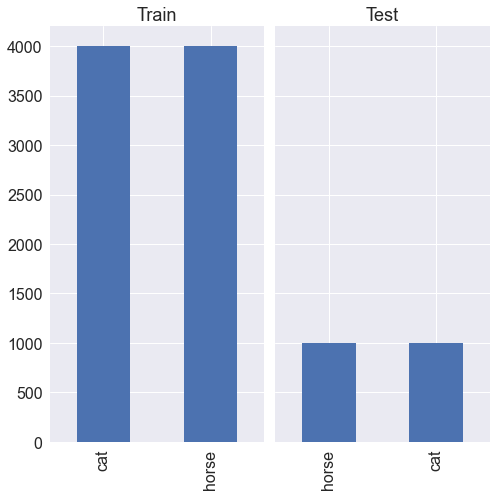

In [8]:
plt.style.use('seaborn')
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(7, 7))

y_train.value_counts().plot(ax=axes[0], kind='bar', fontsize=16)
y_test.value_counts().plot(ax=axes[1], kind='bar', fontsize=16)

axes[0].set_title("Train", fontsize=18)
axes[1].set_title("Test", fontsize=18)

plt.tight_layout()
plt.show()

In [9]:
for index, row in df.iterrows():
    arr = df.loc[index].img
    arr = np.array(arr)
    arr = arr.reshape(1024, -1)
    flat_arr = []
    for i in arr:
        flat_arr.append(i.item())
    df.loc[index].img = flat_arr

In [10]:
cols = np.arange(0, 1024, 1)
data = pd.DataFrame(df['img'].to_list(), columns=cols, index=df.index)
data['label'] = df['label']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['label']), data['label'], test_size=0.2)

In [ ]:
with (open("X_test", "rb")) as openfile:
    while True:
        try:
            X_test = pickle.load(openfile)
        except EOFError:
            break
with (open("y_test", "rb")) as openfile:
    while True:
        try:
            y_test = pickle.load(openfile)
        except EOFError:
            break

In [3]:
with (open("X_train", "rb")) as openfile:
    while True:
        try:
            X_train = pickle.load(openfile)
        except EOFError:
            break
            
with (open("y_train", "rb")) as openfile:
    while True:
        try:
            y_train = pickle.load(openfile)
        except EOFError:
            break

## Minimax Scaler

In [12]:
def normalize(data):
    result = data.copy()
    for feature_name in data.columns:
        max_value = data[feature_name].max()
        min_value = data[feature_name].min()
        result[feature_name] = (data[feature_name] - min_value) / (max_value - min_value)
    return result

In [13]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [26]:
X_train.to_pickle('X_train')
X_test.to_pickle('X_test')
y_train.to_pickle('y_train')
y_test.to_pickle('y_test')

### What happen if we don't normalize the values of each pixel?
Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network.

***
# Part Two: Neural Network
## Dataloader

In [14]:
class Dataloader:
    '''
    This class prepares the dataset for the neural network.
    '''
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        '''
        This is the constructor. It gets dataset information and initializes the 
        Dataloader class fields.
            Parameters:
                data: features your dataset in pandas.Dataframe format.
                labels: labels of your dataset in pandas.Dataframe format.
                n_classes: number of classes you have in your dataset.
                batch_size: the number of samples that will be propagated through the network.
                shuffle: boolean value indicating whether or not the dataset should be shuffled
        '''

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        '''
        This private method gets labels and provides one_hot vectors of labels.
        For categorical variables where no such ordinal relationship exists,
        the integer encoding is not enough.
        In this case, a one-hot encoding can be applied to the integer representation.
        This is where the integer encoded variable is removed, and a new binary variable is
        added for each unique integer value.
        example:
            red,    green,    blue
            1,      0,        0
            0,      1,        0
            0,      0,        1
                Parameters:
                        label: lables of your dataset in pandas.Dataframe format.
                        n_classes: number of classes you have in your dataset.
                
                Returns:
                    onehot_vectors: onehot vectors of the labels
        '''
        # TODO: Implement
        col_name = labels.columns[0]
        onehot_vectors = copy.deepcopy(labels)
        for label in labels[col_name].unique():
            onehot_vectors[label] = 0
        for index, row in onehot_vectors.iterrows():
            onehot_vectors.at[index, row[col_name]] = 1
        onehot_vectors = onehot_vectors.drop(columns='label')
        return onehot_vectors
    
    def __shuffle_dataset(self):
        '''
        This private method shuffles your dataset.
        It uses data and onehot_labels to shuffle them
        symmetrical.
        '''
        # TODO: Implement
        self.__data = self.__data.reindex(np.random.permutation(self.__data.index))
        self.__onehot_labels = self.__onehot_labels.reindex(self.__data.index)
    
    def __iter__(self):
        '''
        The __iter__() function returns an iterator for the
        given object (array, set, tuple, etc., or custom objects).
        This will return your dataset in the batch_size given. This should
        be used to provide data for the neural network.
        '''
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data, dtype=float), np.matrix(self.onehot_labels, dtype=float))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size], dtype=float), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size], dtype=float))

## Activation Functions

In [39]:
class Identical:
    '''
    This is the Identical activation function. This activation function just
    return the value it gets.
    '''
    
    def __init__(self): 
        pass
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        As this is an identical activity function, it just 
        returns np.matrix of the input.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_value: np.matrix of input with float datatypes
        '''
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        '''
        This method returns the derivation of the input.
        As the derivation of x is one, this method returns
        a matrix of one with the shape of the input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_derivative: np.matrix of ones with matrix shape
        '''
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _value method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    

class Relu:
    '''
    This is the Relu activation function. 
    The rectified linear activation function or ReLU for short
    is a piecewise linear function that will output the input directly
    if it is positive, otherwise, it will output zero.
    '''
    
    def __init__(self): 
        pass
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set 0 in the matrix if the value is less than 0 else, it returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        arr = np.asarray(matrix, dtype=float)
        relu_value = arr * (arr > 0)
        relu_value = np.matrix(relu_value, dtype=float)
        return relu_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_derivative: np.matrix of relu activation function derivation result
        '''
        # TODO: Implement
        arr = np.asarray(matrix, dtype=float)
        arr = np.where(arr > 0, 1, 0)
        relu_derivative = np.matrix(arr, dtype=float)
        return relu_derivative
        
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _relu method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __relu(matrix): __relu return value for the input matrix
        '''
        return self.__val(matrix)

    
class LeakyRelu:
    '''
    This is the Leaky Relu activation function. 
    Leaky Rectified Linear Unit, or Leaky ReLU,
    is a type of activation function based on a ReLU,
    but it has a small slope for negative values instead
    of a flat slope.
    '''
    
    def __init__(self, negative_slope=0.01):
        '''
        This is the constructor.
        It sets negative_slope field.
            Parameters:
                negative_slope: slope for negative input values
        '''
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set negative_slope*value in the matrix if the value is less than 0, else it
        returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        arr = np.asarray(matrix, dtype=float)
        leacky_relu_value = np.where(arr > 0, arr, arr * 0.01)
        leacky_relu_value = np.matrix(leacky_relu_value, dtype=float)
        return leacky_relu_value
    
    def derivative(self, matrix):
        '''
        Returns the derivation value of leaky relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                leacky_relu_derivative: np.matrix of leaky relu activation function derivation result
        '''
        # TODO: Implement
        arr = np.asarray(matrix, dtype=float)
        arr = np.where(arr > 0, 1, self.negative_slope)
        leacky_relu_derivative = np.matrix(arr, dtype=float)
        return leacky_relu_derivative
        
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

    
class Sigmoid:
    '''
    A sigmoid function is a mathematical function having a
    characteristic "S"-shaped curve or sigmoid curve.
    It return S(x)=1/(1+e^-x)
    '''
    def __init__(self): 
        pass

    def __val(self, matrix):
        '''
        Returns 1/(1+e^-x) of values
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        arr = np.asarray(matrix, dtype=float)
        sigmoid_value = 1 / (1 + np.exp(-arr))
        sigmoid_value = np.matrix(sigmoid_value, dtype=float)
        return sigmoid_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of sigmoid function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of sigmoid activation function derivation result
        '''
        # TODO: Implement
        sigmoid_value = self.__val(matrix)
        sigmoid_value = np.asarray(sigmoid_value, dtype=float)
        sigmoid_derivative = sigmoid_value * (1 - sigmoid_value)
        sigmoid_derivative = np.matrix(sigmoid_derivative, dtype=float)
        return sigmoid_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)


class Softmax:
    '''
    The softmax function, also known as softargmax  or normalized
    exponential function is a generalization of the logistic
    function to multiple dimensions. It is used in multinomial logistic
    regression and is often used as the last activation function of a neural
    network to normalize the output of a network to a probability distribution
    over predicted output classes, based on Luce's choice axiom.
    Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
    '''
        
    def __init__(self): 
        pass
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''

    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the softmax on that.
        Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        softmax_value = np.zeros(matrix.shape, dtype=float)
        for i in range(len(matrix)):
            softmax_value[i] = np.exp(matrix[i] - np.max(matrix[i]))
            softmax_value[i] = softmax_value[i] / np.sum(softmax_value[i])
        return softmax_value
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self): 
        pass
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''

    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It performs Tanh on the values.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                tanh_value: np.matrix of Tanh activation function result
        '''
        # TODO: Implement
        arr = np.asarray(matrix, dtype=float)
        tanh_value = (np.exp(arr)-np.exp(-arr))/(np.exp(arr)+np.exp(-arr))
        tanh_value = np.matrix(tanh_value, dtype=float)
        return tanh_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of Tanh function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of Tanh activation function derivation result
        '''
        # TODO: Implement
        tanh_value = self.__val(matrix)
        tanh_value = np.asarray(tanh_value)
        tanh_derivative = 1 - tanh_value**2
        tanh_derivative = np.matrix(tanh_derivative, dtype=float)
        return tanh_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

## Loss Function

In [52]:
class CrossEntropy: #(with softmax)
    '''
    Cross-entropy is a measure of the difference between two probability
    distributions for a given random variable or set of events. You might
    recall that information quantifies the number of bits required to encode
    and transmit an event.
    The above image can help you.
    '''
    def __init__(self): 
        self.epsilon = 1e-12
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''

    def __val(self, true_val, expected_val):
        '''
        L(y^, y) = - Σ (y^(k)log (y^)^(k)) for k in K
        Parameters:
            true_val: calculated values (generated by neural network)
            expected_val: real values in dataset
        Returns:
            cross_entropy_value: cross entropy of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
        # TODO: Implement
        softmax = Softmax()
#         true_val = np.matrix(true_val, dtype=float)
#         softmax_values = softmax(true_val)
# #         print(softmax_values)
#         cross_entropy_value = 0
#         for x, y in zip(softmax_values, expected_val):
#             for i, j in zip(x, y):
#                 if i == 0:
#                     i = self.epsilon
#                 cross_entropy_value += -j * np.log2(i)
# #         print(np.sum(cross_entropy_value))
#         return cross_entropy_value

        softmax = Softmax()
        softmax_values = np.clip(softmax(true_val), self.epsilon, 1 - self.epsilon)
        cross_entropy_value = np.sum(np.multiply(-expected_val, np.log(softmax_values)))
        return np.sum(cross_entropy_value)
        
    def derivative(self, true_val, expected_val):
        '''
        Returns derivation of cross entropy.
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                cross_entropy_derivative: cross entropy derivation of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
        # TODO: Implement
        softmax = Softmax()
        return softmax(true_val) - expected_val
    
    def __call__(self, true_val, expected_val):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(true_val, expected_val)

## Layer

In [17]:
class Layer:
    '''
    The layer class is used to define neural network layers.
    It stores all needed information for each layer, such as neurons count,
    weight matrix, bias, the output after applying the activation function, etc.
    '''

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, activation=Identical(), initial_weight='uniform', 
                 **initializing_parameters):
        '''
        Parameters:
            input_size: the size of the input of this layer.
            output_size: the size of the output after this layer.
            activation: the activation function. It can be initialized to either of the previously defined activation classes.
                               default is an Identical activation function.
            initial_weight: either normal or uniform. It defines the method for weight initialization.
        '''
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 
                                          'normal':self.__normal_weight, 
                                          'zero' :self.__zero_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        '''
        It calculates the output of this layer for the layer_input argument.
        This method also stores __last_input, __last_activation_input, and __last_activation_derivative
        for future use in backpropagation.
        Parameters:
            layer_input: 2d np.matrix representing the input matrix of this layer.
        Returns:
            Final output of this layer after applying the activation function.
        '''
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1), f'__weight : {np.size(self.__weight,0)},  layer_input : {np.size(layer_input,1)}!'
        # TODO: Implement
        self.__last_input = layer_input
        self.__last_activation_input = layer_input * self.__weight + self.__bias
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        self.__last_activation_output = self.activation(self.__last_activation_input)
        return self.__last_activation_output
     
    def update_weights(self, backprop_tensor, lr):
        '''
        It updates Layer weights according to the backpropagation matrix and learning rate.
        This method updates bias values as well.
        Parameters:
            backprop_tensor: 2d np.matrix passed from the next layer containing gradient values.
            lr: learning rate
        Returns:
            backprop_tensor to be used by the previous layer.
        '''
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        # TODO: Implement

        last_inp = self.__last_input.transpose()
        E_y = np.multiply(backprop_tensor,self.__last_activation_derivative)
        E_w = np.matmul(last_inp,E_y)
        backprop_tensor = np.matmul(E_y,self.__weight.transpose())
        self.__weight -= E_w*lr
        bu = np.matmul(np.matrix(np.tile(1, (1, E_y.shape[0]))),E_y)
        self.__bias -= bu*lr
        
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a uniform distribution between low and high values.
        It uses default low and high values unless low or high are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom low or high values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using uniformly distributed values.
        '''
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        # TODO: Implement
        weights = np.random.uniform(size=(dim1, dim2), high=high, low=low)
        weights = np.matrix(weights, dtype=float)
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a normal distribution with mean and var values.
        It uses default mean and variance values unless mean or var are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom mean or var values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using normaly distributed values.
        ''' 
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        # TODO: Implement
        weights = np.random.normal(size=(dim1, dim2), loc=mean, scale=var)
        weights = np.matrix(weights, dtype=float)
        return weights
    
    def __zero_weight(self, dim1, dim2, **initializing_parameters):
        # TODO: Implement
        weights = np.zeros(shape=(dim1, dim2))
        weights = np.matrix(weights, dtype=float)
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation
    
    @property
    def last_input(self): return self.__last_input
    
    @property
    def last_activation_output(self): return self.__last_activation_output
    
    

## Network

In [18]:
class FeedForwardNN:
    '''
    This class is used in order to implement custom feed-forward neural networks.
    The FeedForwardNN class stores a list of layers that determines all network layers.
    It also consists of the learning rate and loss function.
    '''
    def __init__(self, input_shape):
        '''
        Parameters:
            input_shape: the size of the first input to our neural network.
        '''
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
        '''
         This method adds a new custom layer to the layers_list.
         Parameters:
             n_neurons: number of neurons in this layer
             activation: the activation function of this layer, default is Relu
             initial_weight: either a uniform or normal, default is uniform
             initializing_parameters: other initializing parameters such as low, high, mean, var, etc
        '''
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        '''
        This method is used to set training parameters.
        Parameters:
            loss: loss function, default is CrossEntropy
            lr: learning rate, default is 1e-3
        '''
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        '''
        This method calculates the output of the complete neural network for a passed input.
        Parameters:
            network_input: input of the neural network
        Returns:
            network_output: output of the neural network after forwarding the network_input
        '''
        assert type(self.__output_shape) != None, "Model is not compiled!"
        # TODO: Implement
        network_output = copy.deepcopy(network_input)
        for layer in self.__layers_list:
            network_output = layer.forward(network_output)
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        '''
        This method trains the neural network using specified parameters.
        It runs the __train private method epoch times and fills the log dictionary.
        Parameters:
            epochs: number of epochs to run
            trainloader: DataLoader for train data
            testloader: DataLoader for test data
            print_results: whether or not to print the results
        Returns:
            log: complete log of the training process as a dictionary consisting of
            train_accuracy, train_loss, test_accuracy, test_loss
        '''
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        '''
        Trains the neural network for one epoch.
        Parameters:
            trainloader: A DataLoader consisting of train data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        batch_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(batch_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        '''
        Test the neural network using a testloader.
        Parameters:
            testloader: A DataLoader of test data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        batch_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(batch_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        '''
        Trains the neural network for one batch of train data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''
        # TODO: Implement
        output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(output, y_batch)
        batch_average_loss = self.__update_weights(output, y_batch)
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        '''
        Tests the neural network for one batch of test data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''  
        # TODO: Implement
        output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(output, y_batch)
        cross_entropy = CrossEntropy()
        batch_average_loss = cross_entropy(output, y_batch) / len(output)
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        '''
        Parameters:
            outputs: output of the neural network
        Returns:
            labels: labels generated from the outputs of the neural network
        '''
        # TODO: Implement
        labels = np.argmax(outputs, axis = 1)
        return labels
    
    def __compute_accuracy(self, output, expected_output):
        '''
        Computes accuracy by comparing output and expected_output.
        Parameters:
            output: actual output of the neural network
            expected_output: expected output
        Returns:
            accuracy
        '''
        # TODO: Implement
        labels = self.__get_labels(output)
        count = 0
        for i in range(len(output)):
            if expected_output[i, labels[i]] == 1:
                count += 1
        accuracy = count / len(output)
        return accuracy
    
    def __update_weights(self, output, y_train):
        '''
        Updates weights of all layers according to neural network output and labels.
        Parameters:
            output: output of the neural network
            y_train: y labels for one batch of train data
        Returns:
            None
        '''
        # TODO: Implement
        entropy = self.__loss.derivative(output, y_train)
        for i in range(len(self.__layers_list)-1, -1, -1):
            entropy = self.__layers_list[i].update_weights(entropy, self.__lr)
        return self.__loss(output, y_train) / len(output)
    
    def get_layers_list(self):
        return self.__layers_list

***
# Part Three: Classification

## Network training

In [19]:
INPUT_SHAPE = 1024
LEARNING_RATE = 0.001
EPOCHS = 25

TRAINLOADER = Dataloader(data = pd.DataFrame(X_train), labels = pd.DataFrame(y_train),
                         n_classes = 2, batch_size = 32, shuffle = False)
TESTLOADER = Dataloader(data = pd.DataFrame(X_test), labels = pd.DataFrame(y_test),
                        n_classes = 2, batch_size = 32, shuffle = False)

In [20]:
network = FeedForwardNN(INPUT_SHAPE)

network.add_layer(n_neurons = 16, activation = Relu(), weight_initializer='uniform')
network.add_layer(n_neurons = 2, activation = Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.506125	Average Loss: 1.1400776085950184
	Test: Average Accuracy: 0.5679563492063492	Average Loss: 0.6817268260272951
Epoch 2:
	Train: Average Accuracy: 0.598	Average Loss: 0.6706572445929188
	Test: Average Accuracy: 0.6051587301587301	Average Loss: 0.6618812410069975
Epoch 3:
	Train: Average Accuracy: 0.6235	Average Loss: 0.6468136594038595
	Test: Average Accuracy: 0.6245039682539683	Average Loss: 0.6358564525880348
Epoch 4:
	Train: Average Accuracy: 0.64375	Average Loss: 0.6251195722672833
	Test: Average Accuracy: 0.6180555555555556	Average Loss: 0.6294251541014118
Epoch 5:
	Train: Average Accuracy: 0.66575	Average Loss: 0.6070118139189842
	Test: Average Accuracy: 0.6354166666666666	Average Loss: 0.6183144161475139
Epoch 6:
	Train: Average Accuracy: 0.686625	Average Loss: 0.5885327838767158
	Test: Average Accuracy: 0.6597222222222222	Average Loss: 0.604471347191157
Epoch 7:
	Train: Average Accuracy: 0.697875	Average Loss: 0.5712382717765845
	Test: 

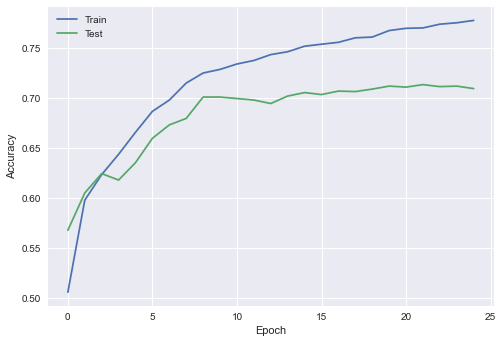

In [28]:
plt.plot(log['train_accuracy'], label='Train')
plt.plot(log['test_accuracy'], label='Test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Network weighting

In [29]:
network = FeedForwardNN(INPUT_SHAPE)

network.add_layer(n_neurons = 16, activation = Relu(), weight_initializer='zero')
network.add_layer(n_neurons = 2, activation = Identical(), weight_initializer='zero')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.518625	Average Loss: 1.2260161726706964
	Test: Average Accuracy: 0.5674603174603174	Average Loss: 0.6800793443426584
Epoch 2:
	Train: Average Accuracy: 0.59825	Average Loss: 0.6685622290379908
	Test: Average Accuracy: 0.6116071428571429	Average Loss: 0.6614150708151745
Epoch 3:
	Train: Average Accuracy: 0.627125	Average Loss: 0.6450953166759024
	Test: Average Accuracy: 0.6324404761904762	Average Loss: 0.6329867167411369
Epoch 4:
	Train: Average Accuracy: 0.647625	Average Loss: 0.6230231778073808
	Test: Average Accuracy: 0.6225198412698413	Average Loss: 0.6281909224848511
Epoch 5:
	Train: Average Accuracy: 0.666	Average Loss: 0.604674328786874
	Test: Average Accuracy: 0.6319444444444444	Average Loss: 0.6186332455535197
Epoch 6:
	Train: Average Accuracy: 0.686875	Average Loss: 0.5868017444024531
	Test: Average Accuracy: 0.652281746031746	Average Loss: 0.6125890901035563
Epoch 7:
	Train: Average Accuracy: 0.701625	Average Loss: 0.5716748336226356
	Test

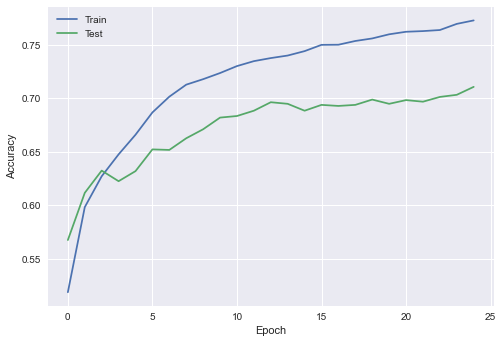

In [30]:
plt.plot(log['train_accuracy'], label='Train')
plt.plot(log['test_accuracy'], label='Test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### The problem of setting all initial weights to zero

#### First, neural networks tend to get stuck in **local minima**, so it's a good idea to give them many different starting values. You can't do that if they all start at zero.<br>
#### Second, if the neurons start with the same weights, then **all the neurons will follow the same gradient**, and will always end up doing the same thing as one another.

## The effect of learning rate 

In [34]:
EPOCHS = 15
lrs = [0.0008, 0.0009, 0.001, 0.002, 0.003]
logs = []
for lr in lrs:
    network = FeedForwardNN(INPUT_SHAPE)
    network.add_layer(n_neurons = 16, activation = Relu(), weight_initializer='uniform')
    network.add_layer(n_neurons = 2, activation = Identical(), weight_initializer='uniform')
    network.set_training_param(loss=CrossEntropy(), lr=lr)

    log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)
    logs.append(log)

Epoch 1:
	Train: Average Accuracy: 0.502875	Average Loss: 1.329657088506586
	Test: Average Accuracy: 0.48115079365079366	Average Loss: 0.7034122675259886
Epoch 2:
	Train: Average Accuracy: 0.564375	Average Loss: 0.6816535884354714
	Test: Average Accuracy: 0.6081349206349206	Average Loss: 0.665008230582086
Epoch 3:
	Train: Average Accuracy: 0.61075	Average Loss: 0.6607055013393492
	Test: Average Accuracy: 0.6205357142857143	Average Loss: 0.6539049770087548
Epoch 4:
	Train: Average Accuracy: 0.629375	Average Loss: 0.6454042906546813
	Test: Average Accuracy: 0.6349206349206349	Average Loss: 0.6392603562068607
Epoch 5:
	Train: Average Accuracy: 0.64275	Average Loss: 0.6300506994828193
	Test: Average Accuracy: 0.6418650793650794	Average Loss: 0.626165718340059
Epoch 6:
	Train: Average Accuracy: 0.6565	Average Loss: 0.6123433918453688
	Test: Average Accuracy: 0.6453373015873016	Average Loss: 0.6135721494576838
Epoch 7:
	Train: Average Accuracy: 0.676125	Average Loss: 0.5955843659791406
	Test

	Train: Average Accuracy: 0.734375	Average Loss: 0.5277127837020382
	Test: Average Accuracy: 0.6870039682539683	Average Loss: 0.5867381657736305
Epoch 11:
	Train: Average Accuracy: 0.7375	Average Loss: 0.521790277258766
	Test: Average Accuracy: 0.6999007936507936	Average Loss: 0.5786494727879787
Epoch 12:
	Train: Average Accuracy: 0.742	Average Loss: 0.5166357133625686
	Test: Average Accuracy: 0.6934523809523809	Average Loss: 0.577767041420659
Epoch 13:
	Train: Average Accuracy: 0.745375	Average Loss: 0.5105494447801217
	Test: Average Accuracy: 0.7028769841269841	Average Loss: 0.5672358921598133
Epoch 14:
	Train: Average Accuracy: 0.748	Average Loss: 0.5056680416826579
	Test: Average Accuracy: 0.7018849206349206	Average Loss: 0.5681227390606945
Epoch 15:
	Train: Average Accuracy: 0.748625	Average Loss: 0.5018474645355557
	Test: Average Accuracy: 0.7058531746031746	Average Loss: 0.5613929635053536
Epoch 1:
	Train: Average Accuracy: 0.568	Average Loss: 0.7809331520091453
	Test: Average A

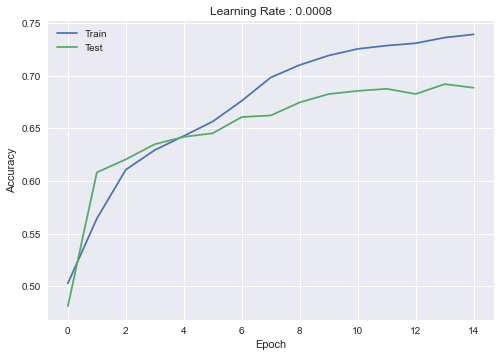

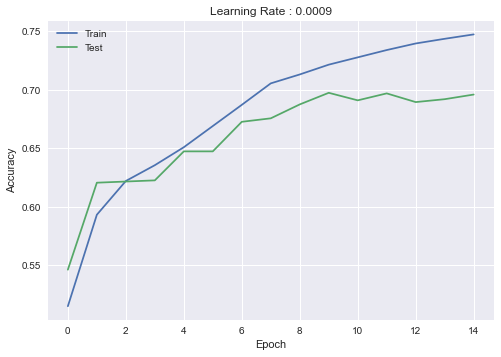

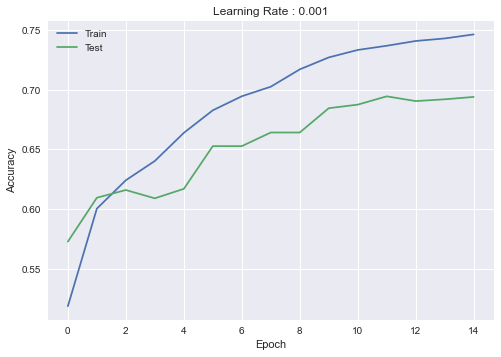

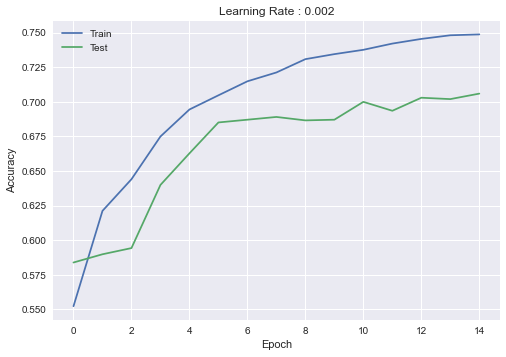

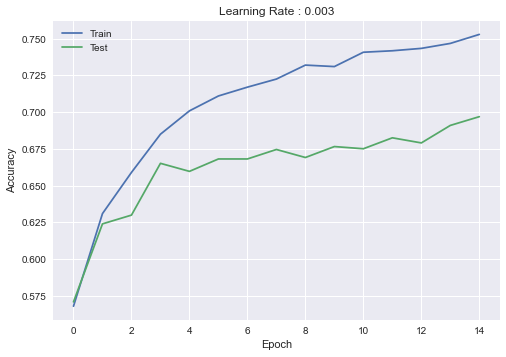

In [35]:
i = 0
for log in logs:
    plt.plot(log['train_accuracy'], label='Train')
    plt.plot(log['test_accuracy'], label='Test')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Rate : {lrs[i]}")
    plt.legend()
    plt.show()
    i += 1

### Best Learning Rate : 0.002

In [36]:
lrs = [0.01, 0.0001]
logs_lr = []
for lr in lrs:
    network = FeedForwardNN(INPUT_SHAPE)
    network.add_layer(n_neurons = 16, activation = Relu(), weight_initializer='uniform')
    network.add_layer(n_neurons = 2, activation = Identical(), weight_initializer='uniform')
    network.set_training_param(loss=CrossEntropy(), lr=lr)

    log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)
    logs_lr.append(log)

Epoch 1:
	Train: Average Accuracy: 0.488625	Average Loss: 0.7440196213298613
	Test: Average Accuracy: 0.5188492063492064	Average Loss: 0.6928606201473695
Epoch 2:
	Train: Average Accuracy: 0.485375	Average Loss: 0.6949961208825244
	Test: Average Accuracy: 0.5188492063492064	Average Loss: 0.6928606201473695
Epoch 3:
	Train: Average Accuracy: 0.485375	Average Loss: 0.6949961208825244
	Test: Average Accuracy: 0.5188492063492064	Average Loss: 0.6928606201473695
Epoch 4:
	Train: Average Accuracy: 0.485375	Average Loss: 0.6949961208825244
	Test: Average Accuracy: 0.5188492063492064	Average Loss: 0.6928606201473695
Epoch 5:
	Train: Average Accuracy: 0.485375	Average Loss: 0.6949961208825244
	Test: Average Accuracy: 0.5188492063492064	Average Loss: 0.6928606201473695
Epoch 6:
	Train: Average Accuracy: 0.485375	Average Loss: 0.6949961208825244
	Test: Average Accuracy: 0.5188492063492064	Average Loss: 0.6928606201473695
Epoch 7:
	Train: Average Accuracy: 0.485375	Average Loss: 0.6949961208825244

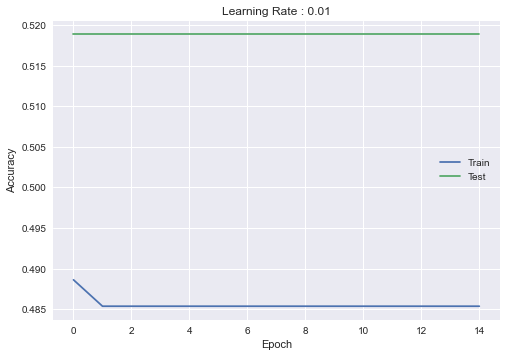

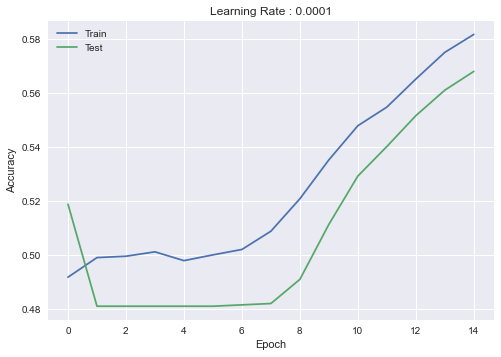

In [37]:
i = 0
for log in logs_lr:
    plt.plot(log['train_accuracy'], label='Train')
    plt.plot(log['test_accuracy'], label='Test')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Rate : {lrs[i]}")
    plt.legend()
    plt.show()
    i += 1

### A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.

## The effect of activation functions

In [42]:
BEST_LEARNING_RATE = 0.002
activations = [Tanh(), Sigmoid(), LeakyRelu()]
logs_activation = []
for activation_function in activations:
    network = FeedForwardNN(INPUT_SHAPE)
    network.add_layer(n_neurons = 16, activation = activation_function, weight_initializer='uniform')
    network.add_layer(n_neurons = 2, activation = Identical(), weight_initializer='uniform')
    network.set_training_param(loss=CrossEntropy(), lr=BEST_LEARNING_RATE)

    log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)
    logs_activation.append(log)

Epoch 1:
	Train: Average Accuracy: 0.490625	Average Loss: 0.7007166534127823
	Test: Average Accuracy: 0.48115079365079366	Average Loss: 0.7036154957132875
Epoch 2:
	Train: Average Accuracy: 0.491375	Average Loss: 0.7006707822243395
	Test: Average Accuracy: 0.48115079365079366	Average Loss: 0.7036154900255275
Epoch 3:
	Train: Average Accuracy: 0.491375	Average Loss: 0.7006707796625536
	Test: Average Accuracy: 0.48115079365079366	Average Loss: 0.7036154843357275
Epoch 4:
	Train: Average Accuracy: 0.491375	Average Loss: 0.7006707771000937
	Test: Average Accuracy: 0.48115079365079366	Average Loss: 0.7036154786438779
Epoch 5:
	Train: Average Accuracy: 0.491375	Average Loss: 0.7006707745369551
	Test: Average Accuracy: 0.48115079365079366	Average Loss: 0.7036154729499698
Epoch 6:
	Train: Average Accuracy: 0.491375	Average Loss: 0.7006707719731338
	Test: Average Accuracy: 0.48115079365079366	Average Loss: 0.7036154672539944
Epoch 7:
	Train: Average Accuracy: 0.491375	Average Loss: 0.7006707694

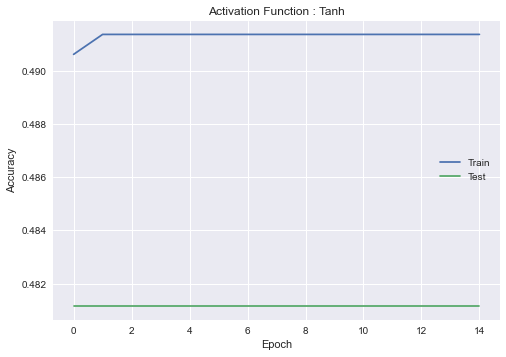

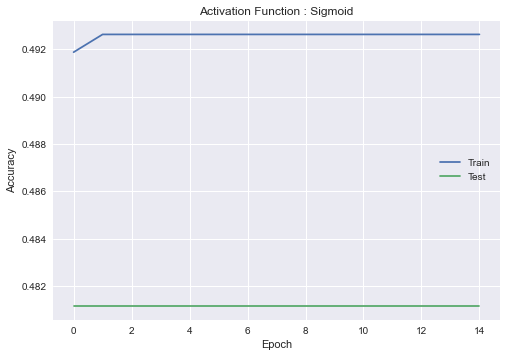

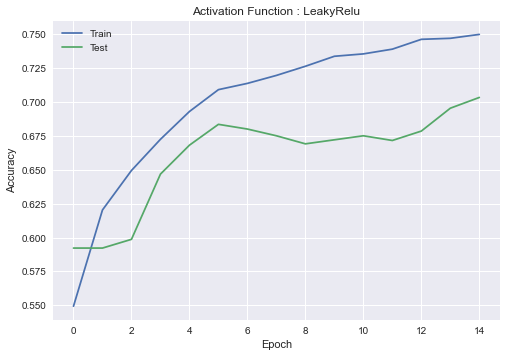

In [43]:
i = 0
for log in logs_activation:
    plt.plot(log['train_accuracy'], label='Train')
    plt.plot(log['test_accuracy'], label='Test')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    if i == 0:
        plt.title("Activation Function : Tanh")
    if i == 1:
        plt.title("Activation Function : Sigmoid")
    if i == 2:
        plt.title("Activation Function : LeakyRelu")
    plt.legend()
    plt.show()
    i += 1

## The effect of batch size

In [47]:
BEST_ACTIVATION = LeakyRelu()
BEST_LEARNING_RATE = 0.002
batch_sizes = [16, 256]
batch_logs= []
for batch_size in batch_sizes:

    TRAINLOADER = Dataloader(data = pd.DataFrame(X_train), labels = pd.DataFrame(y_train),
                             n_classes = 2, batch_size = batch_size, shuffle = False)
    TESTLOADER = Dataloader(data = pd.DataFrame(X_test), labels = pd.DataFrame(y_test),
                            n_classes = 2, batch_size = batch_size, shuffle = False)
    network = FeedForwardNN(INPUT_SHAPE)
    network.add_layer(n_neurons = 16, activation = BEST_ACTIVATION, weight_initializer='uniform')
    network.add_layer(n_neurons = 2, activation = Identical(), weight_initializer='uniform')
    network.set_training_param(loss=CrossEntropy(), lr=BEST_LEARNING_RATE)

    log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)
    batch_logs.append(log)

Epoch 1:
	Train: Average Accuracy: 0.554125	Average Loss: 0.9013622404054522
	Test: Average Accuracy: 0.608	Average Loss: 0.6577822821254473
Epoch 2:
	Train: Average Accuracy: 0.630125	Average Loss: 0.6414153977403546
	Test: Average Accuracy: 0.6365	Average Loss: 0.6202698965779028
Epoch 3:
	Train: Average Accuracy: 0.6605	Average Loss: 0.6101894438879077
	Test: Average Accuracy: 0.658	Average Loss: 0.599559002235304
Epoch 4:
	Train: Average Accuracy: 0.684	Average Loss: 0.5833796572595835
	Test: Average Accuracy: 0.6845	Average Loss: 0.58139945627112
Epoch 5:
	Train: Average Accuracy: 0.704	Average Loss: 0.5640557538433549
	Test: Average Accuracy: 0.702	Average Loss: 0.565642053201146
Epoch 6:
	Train: Average Accuracy: 0.712125	Average Loss: 0.5529737120219729
	Test: Average Accuracy: 0.7045	Average Loss: 0.564498315763191
Epoch 7:
	Train: Average Accuracy: 0.72125	Average Loss: 0.5439805133393728
	Test: Average Accuracy: 0.701	Average Loss: 0.5664369471312641
Epoch 8:
	Train: Average

### Why Sigmoid and Tanh are not good here?
#### The main reason why we use sigmoid or tanh functions is because they are exist between (0 to 1). Therefore, they are especially used for models where we have to predict the probability as an output. Since probability of anything exists only between the range of 0 and 1, sigmoid and tanh are the good.

### What is the advantage of LeakyRelu over Relu?
#### 1- It fixes the “dying ReLU” problem, as it doesn’t have zero-slope parts.(The downside for being zero for all negative values is a problem called “dying ReLU.” A ReLU neuron is “dead” if it’s stuck in the negative side and always outputs 0.)
#### 2- It speeds up training. There is evidence that having the “mean activation” be close to 0 makes training faster. Unlike ReLU, leaky ReLU is more “balanced,” and may therefore learn faster.

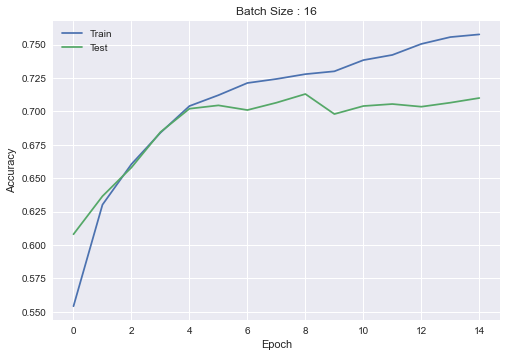

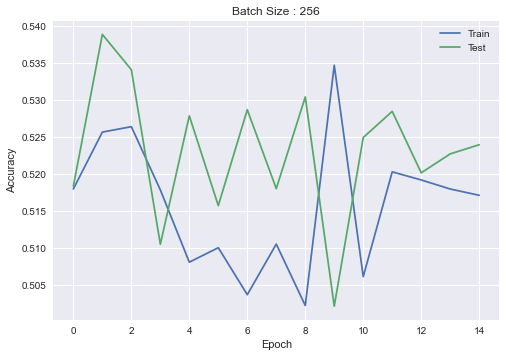

In [48]:
i = 0
for log in batch_logs:
    
    plt.plot(log['train_accuracy'], label='Train')
    plt.plot(log['test_accuracy'], label='Test')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    if i == 0:
        plt.title("Batch Size : 16")
    if i == 1:
        plt.title("Batch Size : 256")

    plt.legend()
    plt.show()
    i += 1

### Why we use batch?
#### Advantages of using a batch size < number of all samples: It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.
#### Typically networks train faster with mini-batches.  If we used all samples during propagation we would make only 1 update for the network's parameter.

### What are the disadvantages of using small batches?
#### Your gradient estimation is very noisy. This may cause your model to either diverge or to converge at a non optimal minima.
#### Sample bias! You are over-fitting the mini-batch distribution and not the actual distribution of the dataset. This means reduced accuracy.
#### You lose the effectiveness of vectorization.

## Best combination

In [53]:
BEST_ACTIVATION = LeakyRelu()
BEST_LEARNING_RATE = 0.002
BEST_BATCH_SIZE = 16
EPOCHS = 25

TRAINLOADER = Dataloader(data = pd.DataFrame(X_train), labels = pd.DataFrame(y_train),
                             n_classes = 2, batch_size = BEST_BATCH_SIZE, shuffle = False)
TESTLOADER = Dataloader(data = pd.DataFrame(X_test), labels = pd.DataFrame(y_test),
                             n_classes = 2, batch_size = BEST_BATCH_SIZE, shuffle = False)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons = 16, activation = BEST_ACTIVATION, weight_initializer='uniform')
network.add_layer(n_neurons = 2, activation = Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=BEST_LEARNING_RATE)

best_log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.55425	Average Loss: 0.915382394194878
	Test: Average Accuracy: 0.5985	Average Loss: 0.6655395103155872
Epoch 2:
	Train: Average Accuracy: 0.629625	Average Loss: 0.6439722664413555
	Test: Average Accuracy: 0.6365	Average Loss: 0.6203176336452463
Epoch 3:


KeyboardInterrupt: 

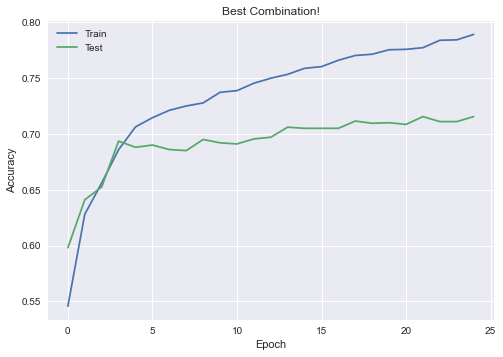

In [51]:
plt.plot(best_log['train_accuracy'], label='Train')
plt.plot(best_log['test_accuracy'], label='Test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Best Combination!")

plt.legend()
plt.show()